In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile
import urllib.request

from discretize import TensorMesh
from discretize.utils import active_from_xyz
from simpeg.utils import plot2Ddata, model_builder
from simpeg.potential_fields import gravity
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

import numpy as np
import matplotlib.pyplot as plt
from discretize import TreeMesh
from discretize.utils import mkvc

# sphinx_gallery_thumbnail_number = 3

In [2]:

import matplotlib
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

from discretize import TensorMesh

# from SimPEG.potential_fields import magnetics
# from SimPEG import dask
# from SimPEG.utils import plot2Ddata, surface2ind_topo
from SimPEG import (
    maps,
    data,
    inverse_problem,
    data_misfit,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
import pandas as pd
from ipywidgets import widgets, interact

C:\Users\gabri\AppData\Local\Temp\ipykernel_4240\3764283650.py:13: FutureWarning: Importing `SimPEG` is deprecated. please import from `simpeg`.
  from SimPEG import (


In [3]:
import os
import urllib.request
import tarfile

# Enlace de Google Drive (modificado para descarga directa)
data_source = "https://drive.google.com/uc?export=download&id=10aEQOnrprAyIFMWPicd8ZAznM1UDCol9"

# Descargar el archivo y guardar el nombre local
downloaded_data = "data.tar.gz"
print(f"Downloading data from: {data_source}")
urllib.request.urlretrieve(data_source, downloaded_data)
print(f"File downloaded: {downloaded_data}")

# Descomprimir el archivo .tar.gz
if tarfile.is_tarfile(downloaded_data):
    with tarfile.open(downloaded_data, "r:gz") as tar:
        # Extraer los archivos al directorio actual
        tar.extractall()
    print("Files extracted.")
else:
    print("The downloaded file is not a tar.gz file.")

# Definir el directorio que contiene los datos descomprimidos
dir_path = os.path.join("Inv_Gravity_Anomaly_3D_VCM", "")  # Ruta a la carpeta descomprimida

# Nombres de los archivos con rutas completas
topo_filename = os.path.join(dir_path, "gravity_topo_480.txt")
data_filename = os.path.join(dir_path, "gravity_data_480_e001 (1).txt")

# Verificación de los archivos
if os.path.exists(topo_filename):
    print(f"Topo file located: {topo_filename}")
else:
    print(f"Topo file not found: {topo_filename}")

if os.path.exists(data_filename):
    print(f"Data file located: {data_filename}")
else:
    print(f"Data file not found: {data_filename}")



File downloaded: data.tar.gz
Files extracted.
Topo file located: Inv_Gravity_Anomaly_3D_VCM\gravity_topo_480.txt
Data file located: Inv_Gravity_Anomaly_3D_VCM\gravity_data_480_e001 (1).txt


In [4]:
# Load topography
xyz_topo = np.loadtxt(str(topo_filename))
xyz_topo

array([[853650. , 987570. ,   2248.9],
       [853710. , 987570. ,   2298.2],
       [853780. , 987570. ,   2331.1],
       ...,
       [855400. , 988560. ,   2519.7],
       [855470. , 988560. ,   2530.4],
       [855530. , 988560. ,   2558.3]])

In [5]:
# Load field data
dobs = np.loadtxt(str(data_filename))
dobs

array([[ 8.5365e+05,  9.8757e+05,  2.2539e+03, -7.7075e+00],
       [ 8.5371e+05,  9.8757e+05,  2.3032e+03, -8.1108e+00],
       [ 8.5378e+05,  9.8757e+05,  2.3361e+03, -8.7837e+00],
       ...,
       [ 8.5540e+05,  9.8856e+05,  2.5247e+03, -9.6013e+00],
       [ 8.5547e+05,  9.8856e+05,  2.5354e+03, -8.6401e+00],
       [ 8.5553e+05,  9.8856e+05,  2.5633e+03, -8.1575e+00]])

In [6]:
# Definir las ubicaciones de los receptores y los datos observados
receiver_locations = dobs[:, 0:3]
dobs = dobs[:, -1]

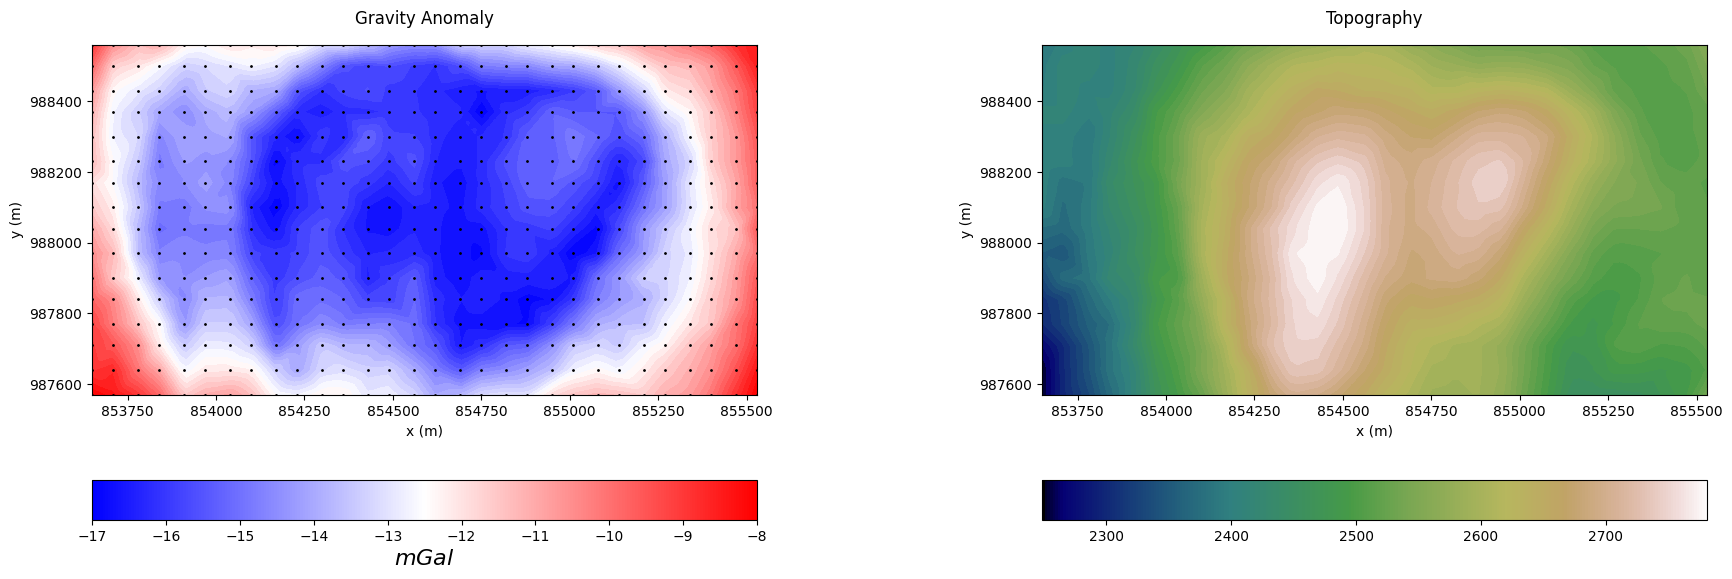

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# Suponiendo que ya tienes definidos receiver_locations y dobs

# Normalizar los datos manualmente
norm = mpl.colors.Normalize(vmin=-17, vmax=-8)
dobs_normalized = norm(dobs)  # Normalizar los datos 'dobs'
# dobs=dobs_normalized

# Crear la figura
fig = plt.figure(figsize=(19, 10))

# Crear el primer gráfico
ax1 = fig.add_axes([0.05, 0.35, 0.35, 0.6])
# Pasar los datos normalizados en lugar de la normalización directamente
plot2Ddata(
    receiver_locations,
    dobs_normalized,  # Usar los datos normalizados
    ax=ax1,
    dataloc=True,
    ncontour=40,
    contourOpts={"cmap": "bwr"},
)
ax1.set_title("Gravity Anomaly", pad=15)
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

# Barra de color para la primera figura
cx1 = fig.add_axes([0.05, 0.35, 0.35, 0.04])
# Usar la normalización para la barra de colores
cbar1 = mpl.colorbar.ColorbarBase(
    cx1, norm=norm, orientation="horizontal", cmap=mpl.cm.bwr
)
cbar1.set_label("$mGal$", size=16)

# Segunda figura (topografía), sigue sin cambios
ax2 = fig.add_axes([0.55, 0.35, 0.35, 0.6])
plot2Ddata(
    xyz_topo[:, 0:2],
    xyz_topo[:, -1],
    ax=ax2,
    ncontour=50,
    contourOpts={"cmap": "gist_earth"},
)
ax2.set_title("Topography", pad=15)
ax2.set_xlabel("x (m)")
ax2.set_ylabel("y (m)")

# Barra de color para la segunda figura
cx2 = fig.add_axes([0.55, 0.35, 0.35, 0.04])
norm2 = mpl.colors.Normalize(vmin=np.min(xyz_topo[:, -1]), vmax=np.max(xyz_topo[:, -1]))
cbar2 = mpl.colorbar.ColorbarBase(
    cx2, norm=norm2, orientation="horizontal", cmap=mpl.cm.gist_earth
)

plt.savefig('mapas.png', dpi=300)

In [8]:
#Definir desviación estandar de nuestros datos, en este caso, será de 1
maximum_anomaly = np.max(np.abs(dobs))
floor_uncertainty = 0.01 * maximum_anomaly
uncertainties = floor_uncertainty * np.ones(np.shape(dobs))
print("Floor uncertainty: {}".format(floor_uncertainty))
dobs

Floor uncertainty: 0.17314000000000002


array([ -7.7075,  -8.1108,  -8.7837,  -9.7012, -11.57  , -10.996 ,
       -10.755 , -11.307 , -12.54  , -12.754 , -12.249 , -12.256 ,
       -12.918 , -12.792 , -13.296 , -14.167 , -13.895 , -13.219 ,
       -13.028 , -13.082 , -11.9   , -11.445 , -11.195 , -11.327 ,
       -11.567 , -11.001 , -10.663 ,  -9.9389,  -8.674 ,  -7.6962,
        -8.7147,  -8.4539,  -9.9445, -10.89  , -12.709 , -12.111 ,
       -12.087 , -12.251 , -13.445 , -14.176 , -13.226 , -13.093 ,
       -13.373 , -13.304 , -14.07  , -14.9   , -15.645 , -14.85  ,
       -14.596 , -14.289 , -13.711 , -12.754 , -12.378 , -12.724 ,
       -12.18  , -11.541 , -11.002 , -10.426 ,  -9.287 ,  -8.1058,
        -8.8528,  -9.3382, -10.4   , -12.168 , -13.567 , -12.847 ,
       -12.896 , -13.329 , -15.228 , -14.349 , -13.5   , -13.864 ,
       -13.92  , -14.331 , -15.105 , -15.621 , -16.84  , -16.412 ,
       -15.629 , -15.538 , -14.609 , -13.544 , -13.266 , -13.546 ,
       -12.734 , -12.297 , -11.403 , -10.729 ,  -9.8313,  -8.6

In [9]:
# Definir los receptores (con los puntos XYZ). Los datos consisten en mediciones de anomalías verticales de gravedad. 
# El conjunto de receptores debe definirse como una lista.
receiver_list = gravity.receivers.Point(receiver_locations, components="gz")
receiver_list = [receiver_list]

# Definir el campo de la fuente
source_field = gravity.sources.SourceField(receiver_list=receiver_list)

# Define el survey (sondeo)
survey = gravity.survey.Survey(source_field)

In [10]:
#Definir los datos que serán invertidos
data_object = data.Data(survey, dobs=-dobs, standard_deviation=uncertainties)

<Axes3D: xlabel='x1', ylabel='x2', zlabel='x3'>

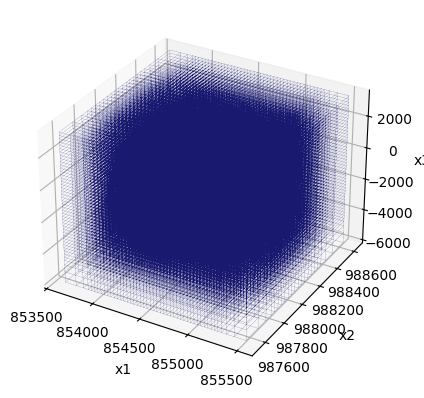

In [11]:
#definir la malla
dx = 35
ncx = 40
dy = 37
ncy = 15
dz = 200
ncz = 40
dpadh = 3.5
exp_h = 1.5

hx = [(dx, dpadh, -exp_h), (dx, ncx), (dx, dpadh, exp_h)]
hy = [(dy, dpadh, -exp_h), (dy, ncy), (dy, dpadh, exp_h)]
hz = [(dz, 3, -exp_h), (dz, ncz)]
mesh = TensorMesh([hx, hy, hz], x0=[853614,987543,-6000])

                           
mesh.plot_grid(color="midnightblue", linewidth=0.1)

In [12]:
#Modelo inicial/de referencia y mapeo en la malla tensorial
#Creamos el modelo de partida para la inversión desde el espacio del modelo a las celdas vacías
#Los modelos de partida y de referencia pueden ser un valor de fondo constante

# Encuentra los índices de las celdas activas en el modelo de avance (las que están por debajo de la superficie)
active_tensor_cells = active_from_xyz(mesh, xyz_topo)

# Definir la asignación del modelo a las celdas activas
n_tensor_active = int(active_tensor_cells.sum())

#Mapping from the Model to Active Cells
tensor_model_map = maps.IdentityMap(nP=n_tensor_active)  #El modelo consiste en un valor para cada celda activa



In [13]:
# Definir y trazar el modelo inicial
starting_tensor_model = 0.5 * np.ones(n_tensor_active)
reference_tensor_model = np.zeros_like(starting_tensor_model)

In [14]:
# Map for ignoring inactive cells when plotting
tensor_plotting_map = maps.InjectActiveCells(mesh, active_tensor_cells, np.nan)

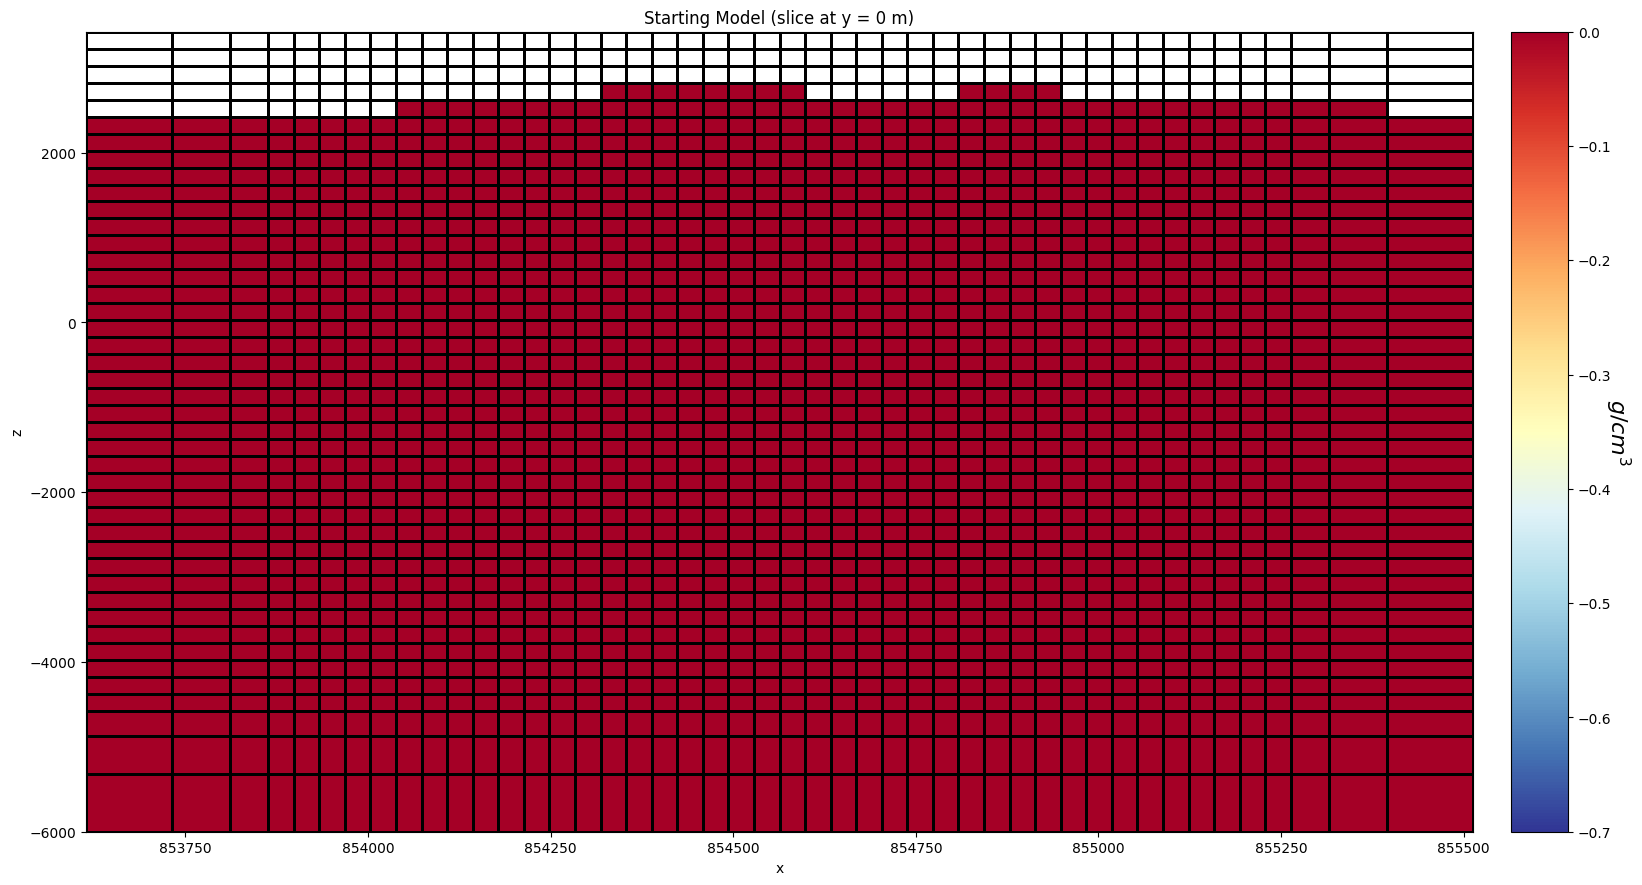

In [15]:
fig = plt.figure(figsize=(19, 10))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(vmin=-0.7, vmax=0.0)
mesh.plot_slice(
    tensor_plotting_map * starting_tensor_model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.shape_cells[1] / 2),
    grid=True,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)

ax1.set_title("Starting Model (slice at y = 0 m)")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

plt.show()

In [16]:
#Definimos la física del problema de la gravedad utilizando la clase de simulación.
simulation_L2 = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    rhoMap=tensor_model_map,
    ind_active=active_tensor_cells,
    engine="choclo",
)

In [17]:
#Definición del problema inverso

# Definir el desajuste de datos. Aquí el desajuste de datos es la norma L2 del residuo 
# ponderado entre los datos observados y los datos predichos para un modelo dado.
# Dentro del desajuste de datos, el residuo entre los datos predichos y observados son
# normalizados por la desviación estándar de los datos.
dmis_L2 = data_misfit.L2DataMisfit(data=data_object, simulation=simulation_L2)
dmis_L2.W = utils.sdiag(1 / uncertainties)



# Definir la regularización (función objetivo del modelo).

reg_L2 = regularization.WeightedLeastSquares(
    mesh,
    active_cells=active_tensor_cells,
    mapping=tensor_model_map,
    length_scale_x=1.0,
    length_scale_y=1.0,
    length_scale_z=10.0,
    reference_model=reference_tensor_model,
    reference_model_in_smooth=True,
)

# reg_L2 = regularization.WeightedLeastSquares(
#     mesh, 
#     active_cells=active_tensor_cells,
#     mapping=tensor_model_map,
#     alpha_s=1e-5, 
#     alpha_x=1/5, 
#     alpha_y=1/5, 
#     alpha_z=1/3, 
#     alpha_xx=1/5, 
#     alpha_yy=1/5, 
#     alpha_zz=1/2,
#     reference_model=reference_tensor_model, 
#     reference_model_in_smooth=True, 

# )



In [18]:
# Definir cómo se resuelve el problema de optimización. Aquí vamos a utilizar un enfoque
# Gauss-Newton proyectado que emplea el solucionador de gradiente conjugado.
opt_L2 = optimization.InexactGaussNewton(
           maxIter=110, maxIterLS=30, maxIterCG=100, tolCG=1e-3
)

In [19]:
# Aquí definimos el problema inverso que hay que resolver
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

In [20]:
# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputDictEveryIteration()
save_iteration.outDict = {}

# Add sensitivity weights
sensitivity_weights = directives.UpdateSensitivityWeights(every_iteration=False, 
                                                          threshold_value=1e-10, 
                                                          threshold_method='amplitude', 
                                                          normalization_method='maximum')
                                                         # )
# Updating the preconditionner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
# Definir un valor inicial para el parámetro de compensación (beta) entre el 
# desajuste de los datos y la regularización.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)
# Taza de diminución del valor de Beta
beta_schedule = directives.BetaSchedule(coolingFactor=10.0, coolingRate=1) 

target_misfit = directives.TargetMisfit(chifact=0.02)



# The directives are defined as a list.
directives_list_L2 = [
    sensitivity_weights,
    update_jacobi,
    starting_beta,
    beta_schedule,
    target_misfit,
    save_iteration,
]



In [21]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run inversion
recovered_tensor_model = inv_L2.run(starting_tensor_model)


Running inversion with SimPEG v0.22.1

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.15e-03  1.08e+07  8.14e+07  1.10e+07    2.40e+05      0              


c:\Users\gabri\anaconda3\envs\volcan\lib\site-packages\simpeg\optimization.py:1072: UserWarning: tol is not a valid keyword for cg and will be ignored
  Hinv = SolverICG(


   1  3.15e-04  3.04e+04  8.17e+07  5.61e+04    9.76e+03      0              
   2  3.15e-05  2.00e+03  1.00e+08  5.16e+03    1.24e+03      0   Skip BFGS  
   3  3.15e-06  5.68e+02  1.13e+08  9.23e+02    1.78e+02      0   Skip BFGS  
   4  3.15e-07  3.00e+02  1.40e+08  3.44e+02    2.86e+01      0   Skip BFGS  
   5  3.15e-08  1.70e+02  2.91e+08  1.79e+02    6.83e+00      0   Skip BFGS  
   6  3.15e-09  9.55e+01  1.08e+09  9.89e+01    8.23e+00      0   Skip BFGS  
   7  3.15e-10  6.49e+01  3.21e+09  6.59e+01    1.22e+01      0   Skip BFGS  
   8  3.15e-11  5.58e+01  3.84e+09  5.60e+01    9.04e+00      0              
   9  3.15e-12  5.06e+01  4.68e+09  5.06e+01    4.94e+00      0              
  10  3.15e-13  4.69e+01  5.43e+09  4.69e+01    5.43e+00      0              
  11  3.15e-14  4.41e+01  6.02e+09  4.41e+01    3.77e+00      0              
  12  3.15e-15  4.20e+01  6.69e+09  4.20e+01    4.60e+00      0              
  13  3.15e-16  4.01e+01  7.26e+09  4.01e+01    5.42e+00      0 

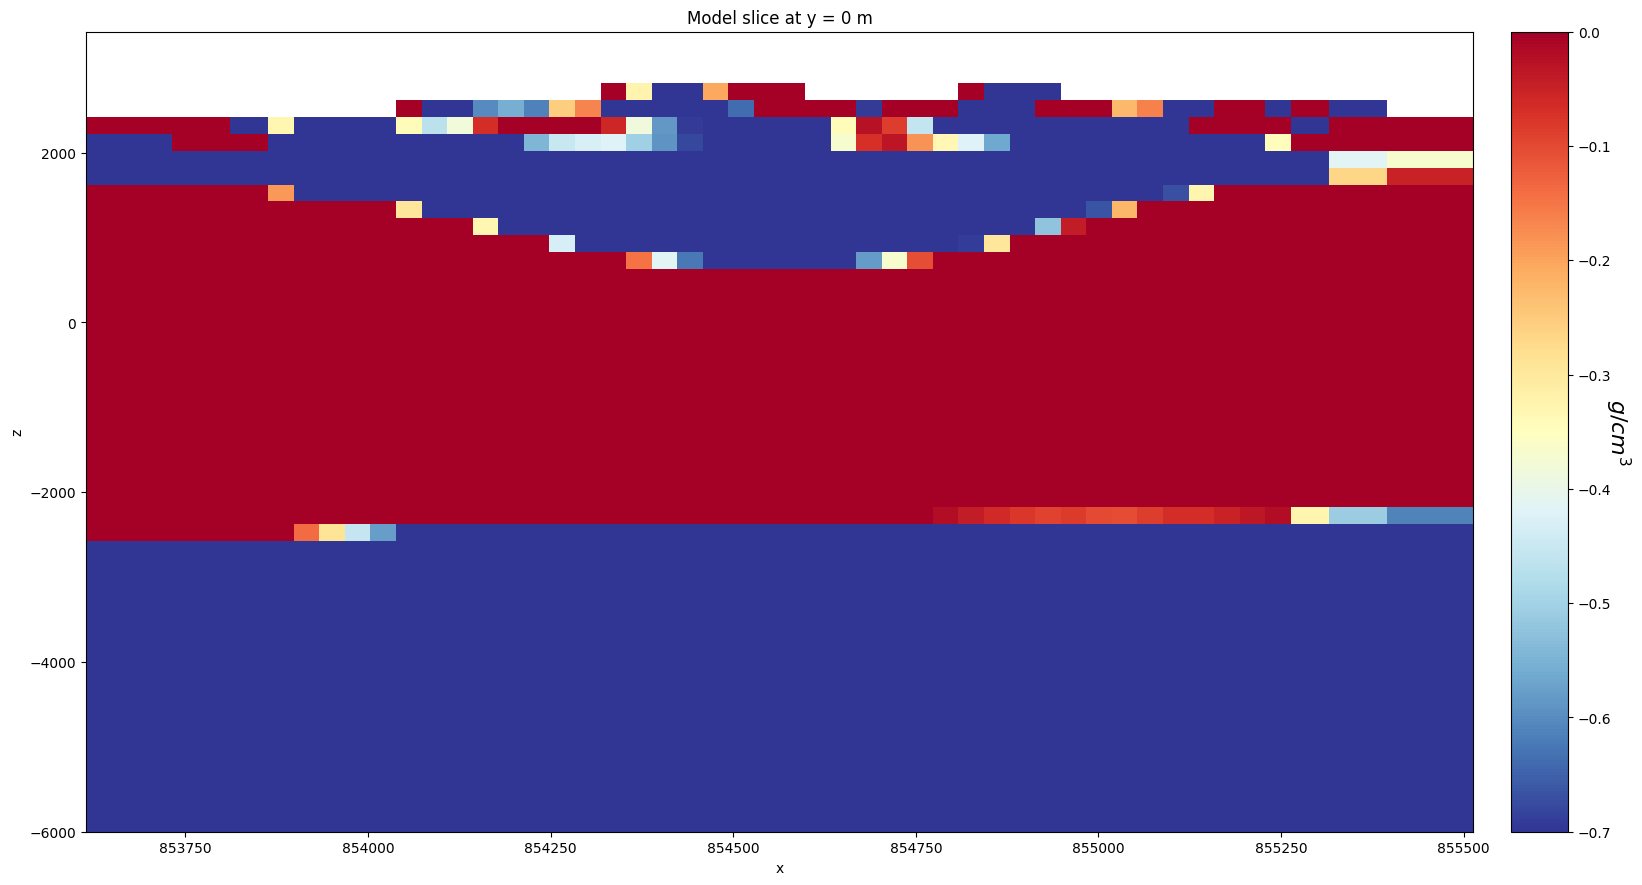

In [22]:
# Plot Recovered Model
fig = plt.figure(figsize=(19, 10))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

# norm = mpl.colors.Normalize(
#     vmin=np.min(recovered_tensor_model), vmax=np.max(recovered_tensor_model)
# )

norm = mpl.colors.Normalize(vmin=-0.7, vmax=0.0)

mesh.plot_slice(
    tensor_plotting_map * recovered_tensor_model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.shape_cells[1] / 2),
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)
ax1.set_title("Model slice at y = 0 m")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

plt.show()


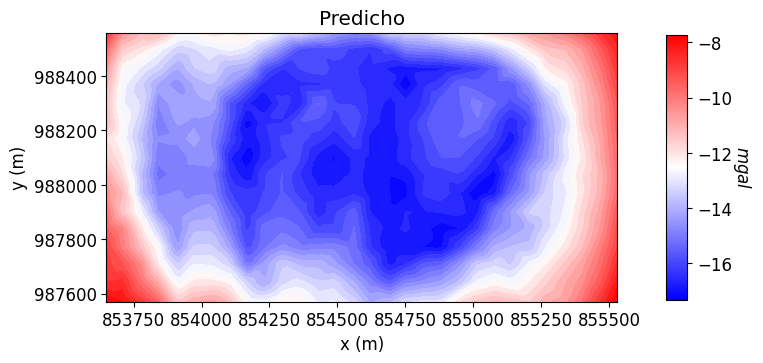

In [23]:
dpred = (-inv_prob_L2.dpred)

# Plot
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

v_lim = [np.min(dpred), np.max(dpred), np.min(-dpred), np.max(-dpred)]

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(
    receiver_list[0].locations,
    dpred, 
    ax=ax1,
    ncontour=30,
    clim=(v_lim[0], v_lim[1]),
    contourOpts={"cmap": "bwr"})
ax1.set_title("Predicho")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=v_lim[0], vmax=v_lim[1])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

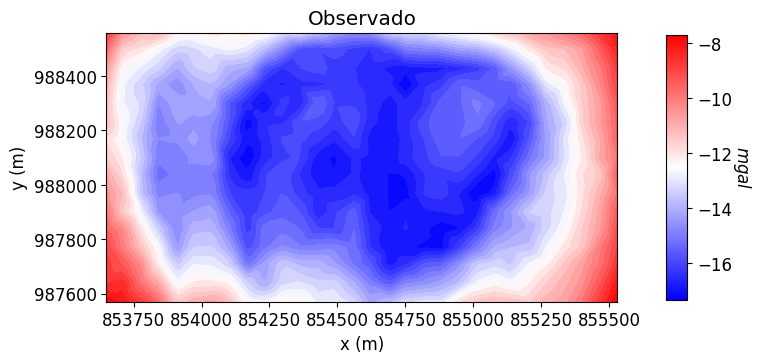

In [24]:

mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(receiver_locations, dobs, ax=ax1, ncontour=30, contourOpts={"cmap": "bwr"})
ax1.set_title("Observado")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=-np.max(-dobs), vmax=np.max(dobs))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

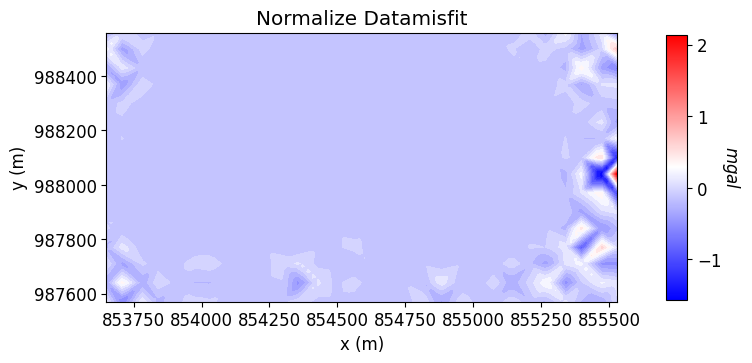

In [25]:
data_misfit= (dobs - dpred) / uncertainties


mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(receiver_locations,
           data_misfit,
           ax=ax1,
           ncontour=30,
           contourOpts={"cmap": "bwr"})
ax1.set_title("Normalize Datamisfit")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=-np.max(-data_misfit), vmax=np.max(data_misfit))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

In [26]:
def plot_tikhonov_curve(iteration, scale):
    phi_d = []
    phi_m = []
    beta = []
    iterations = np.arange(len(save_iteration.outDict)) + 1
    for kk in iterations:
        phi_d.append(save_iteration.outDict[kk]['phi_d'])
        phi_m.append(save_iteration.outDict[kk]['phi_m'])
        beta.append(save_iteration.outDict[kk]['beta'])
    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    axs[0].plot(phi_m ,phi_d, 'k.-')
    axs[0].plot(phi_m[iteration-1] ,phi_d[iteration-1], 'go', ms=10)
    axs[0].set_xlabel("$\phi_m$")
    axs[0].set_ylabel("$\phi_d$")
    axs[0].grid(True)

    axs[1].plot(iterations, phi_d, 'k.-')
    axs[1].plot(iterations[iteration-1], phi_d[iteration-1], 'go', ms=10)
    ax_1 = axs[1].twinx()
    ax_1.plot(iterations, phi_m, 'r.-')
    ax_1.plot(iterations[iteration-1], phi_m[iteration-1], 'go', ms=10)
    axs[1].set_ylabel("$\phi_d$")
    ax_1.set_ylabel("$\phi_m$")
    axs[1].set_xlabel("Iterations")
    axs[1].grid(True)
    axs[0].set_title(
        "$\phi_d$={:.1e}, $\phi_m$={:.1e}, $\\beta$={:.1e}".format(phi_d[iteration-1], phi_m[iteration-1], beta[iteration-1]),
        fontsize = 14
    )
    axs[1].set_title("Target misfit={:.0f}".format(survey.nD/2))
    for ii, ax in enumerate(axs):        
        if ii == 0:
            ax.set_xscale(scale)        
        ax.set_yscale(scale)
        xlim = ax.get_xlim()
        ax.hlines(survey.nD/2, xlim[0], xlim[1], linestyle='--', label='$\phi_d^{*}$')
        ax.set_xlim(xlim)
    axs[0].legend()
    plt.tight_layout() 

In [27]:
def plot_tikhonov_curve(iteration, scale):
    phi_d = []
    phi_m = []
    beta = []
    iterations = np.arange(len(save_iteration.outDict)) + 1
    for kk in iterations:
        phi_d.append(save_iteration.outDict[kk]['phi_d'])
        phi_m.append(save_iteration.outDict[kk]['phi_m'])
        beta.append(save_iteration.outDict[kk]['beta'])
    
    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    
    # Primera gráfica
    axs[0].plot(phi_m, phi_d, 'k.-')
    axs[0].plot(phi_m[iteration-1], phi_d[iteration-1], 'go', ms=10)
    axs[0].set_xlabel("$\phi_m$")
    axs[0].set_ylabel("$\phi_d$")
    axs[0].grid(True)
    
    # Segunda gráfica
    line1 = axs[1].plot(iterations, phi_d, 'k.-', label='$\phi_d$')
    point1 = axs[1].plot(iterations[iteration-1], phi_d[iteration-1], 'go', ms=10)
    
    ax_1 = axs[1].twinx()
    line2 = ax_1.plot(iterations, phi_m, 'r.-', label='$\phi_m$')
    point2 = ax_1.plot(iterations[iteration-1], phi_m[iteration-1], 'go', ms=10)
    
    axs[1].set_ylabel("$\phi_d$")
    ax_1.set_ylabel("$\phi_m$")
    axs[1].set_xlabel("Iterations")
    axs[1].grid(True)
    
    # Añadir leyendas
    lines = line1 + line2
    labels = [line.get_label() for line in lines]
    axs[1].legend(lines, labels, loc='upper left')
    
    axs[0].set_title(
        "$\phi_d$={:.1e}, $\phi_m$={:.1e}, $\\beta$={:.1e}".format(phi_d[iteration-1], phi_m[iteration-1], beta[iteration-1]),
        fontsize = 14
    )
    axs[1].set_title("Target misfit={:.0f}".format(survey.nD/2))
    
    for ii, ax in enumerate(axs):        
        if ii == 0:
            ax.set_xscale(scale)        
        ax.set_yscale(scale)
        xlim = ax.get_xlim()
        ax.hlines(survey.nD/2, xlim[0], xlim[1], linestyle='--', label='$\phi_d^{*}$')
        ax.set_xlim(xlim)
    
    axs[0].legend()
    plt.tight_layout()    

interact(
    plot_tikhonov_curve, 
    iteration=widgets.IntSlider(min=1, max=len(save_iteration.outDict), step=1),
    scale=widgets.RadioButtons(options=["linear", "log"])
)

interactive(children=(IntSlider(value=1, description='iteration', max=110, min=1), RadioButtons(description='s…

<function __main__.plot_tikhonov_curve(iteration, scale)>

In [28]:
def plot_dobs_vs_dpred(iteration):
    # Predicted data with final recovered model
    dpred_new = save_iteration.outDict[iteration]['dpred']

    # Observed data | Predicted data | Normalized data misfit
    data_array = np.c_[dobs, dpred, (dobs - dpred) / uncertainties]
    vmin, vmax = dobs.min(), dobs.max()
    fig = plt.figure(figsize=(17, 4))
    plot_title = ["Observed", "Predicted", "Normalized Misfit"]
    plot_units = ["nT", "nT", ""]

    ax1 = 3 * [None]
    ax2 = 3 * [None]
    norm = 3 * [None]
    cbar = 3 * [None]
    cplot = 3 * [None]
    v_lim = [(vmin, vmax), (vmin, vmax),(-3,3)]

    for ii in range(0, 3):

        ax1[ii] = fig.add_axes([0.33 * ii + 0.03, 0.11, 0.22, 0.84])
        cplot[ii] = plot2Ddata(
            receiver_list[0].locations,
            data_array[:, ii],
            ax=ax1[ii],
            ncontour=30,
            clim=v_lim[ii],
            contourOpts={"cmap": "Spectral_r"},
        )
        ax1[ii].set_title(plot_title[ii])
        ax1[ii].set_xlabel("x (m)")
        ax1[ii].set_ylabel("y (m)")

        ax2[ii] = fig.add_axes([0.33 * ii + 0.27, 0.11, 0.01, 0.84])
        norm[ii] = mpl.colors.Normalize(vmin=v_lim[ii][0], vmax=v_lim[ii][1])
        cbar[ii] = mpl.colorbar.ColorbarBase(
            ax2[ii], norm=norm[ii], orientation="vertical", cmap=mpl.cm.Spectral_r
        )
        cbar[ii].set_label(plot_units[ii], rotation=270, labelpad=15, size=12)
    for ax in ax1[1:]:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    plt.show()

In [29]:
interact(plot_dobs_vs_dpred, iteration=widgets.IntSlider(min=1, max=len(save_iteration.outDict), step=1, value=1))

interactive(children=(IntSlider(value=1, description='iteration', max=110, min=1), Output()), _dom_classes=('w…

<function __main__.plot_dobs_vs_dpred(iteration)>

In [30]:
# def plot_recovered_model(iteration, xslice, yslice, zslice, vmax):
#     fig = plt.figure(figsize=(10, 10))
#     mesh.plot_3d_slicer(
#         save_iteration.outDict[iteration]['m'], clim=(0, vmax),
#         xslice=xslice,
#         yslice=yslice,
#         zslice=zslice,
#         fig=fig,
#         pcolor_opts={'cmap':'Spectral_r'}
#     )
# interact(
#     plot_recovered_model, 
#     iteration=widgets.IntSlider(min=1, max=len(save_iteration.outDict), value=0),
#     xslice=widgets.FloatText(value=855500, step=100),
#     yslice=widgets.FloatText(value=988400, step=100),
#     zslice=widgets.FloatText(value=-6000, step=100),
#     vmax=widgets.FloatText(value=0.07),
# )

In [31]:
# # Crear un modelo que incluye todas las celdas de la malla
# if save_iteration.outDict[iteration]['m'].size < mesh.n_tensor_active:
#     model = np.zeros(mesh.n_tensor_active)  # Inicia con ceros
#     model[mesh.active_tensor_cells] = save_iteration.outDict[iteration]['m']  # Asigna valores a las celdas activas
# else:
#     model = save_iteration.outDict[iteration]['m']

In [32]:
# import pyvista as pv
# def plot_3d_with_pyvista(model, notebook=True, threshold=0.04):
#     pv.set_plot_theme("document")
#     # Get the PyVista dataset of the inverted model
#     dataset = mesh.to_vtk({'susceptibility':model})
#     # Create the rendering scene
#     p = pv.Plotter(notebook=notebook)
#     # add a grid axes
#     p.show_grid()
#     # Extract volumetric threshold
#     threshed = dataset.threshold(threshold, invert=False)
#     # Add spatially referenced data to the scene
#     dparams = dict(
#         show_edges=False,
#         cmap="Spectral_r",
#         clim=[0, 0.1],
#         stitle='sus', 
#     )
#     p.add_mesh(threshed, **dparams)
#     p.set_scale(1,1,1)
#     cpos = [(-5090.61095767987, 35424.20054814459, 5280.45524943451),
#      (2298.051317829793, 40974.692421295964, -864.2486811315523),
#      (0.4274014723619113, 0.35262874486945933, 0.8324547733749025)]
#     p.camera_position = cpos
#     p.show(window_size=[1024, 768])

In [33]:
# plot_3d_with_pyvista(recovered_model, notebook=True, threshold=0.04)

In [34]:
# Compute normalized data misfits
normalized_data_misfits = (dobs - dpred) / uncertainties

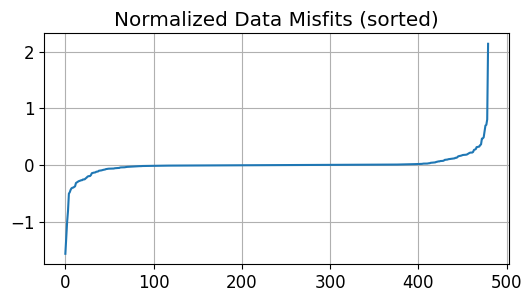

In [35]:
# Plot the normalized data misfits
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)
ax.plot(np.sort(normalized_data_misfits))
ax.set_title("Normalized Data Misfits (sorted)")
ax.grid()
plt.show(fig)

In [36]:
# Generate new uncertainties
new_uncertainties = uncertainties.copy()
new_uncertainties[np.abs(normalized_data_misfits) > 2.0] /= 2.5

In [37]:
# Generate new data object
new_data_object = data.Data(survey, dobs=dobs, standard_deviation=new_uncertainties)


Text(0.5, 1.0, 'Cell Log-Volumes at Y = 0 m')

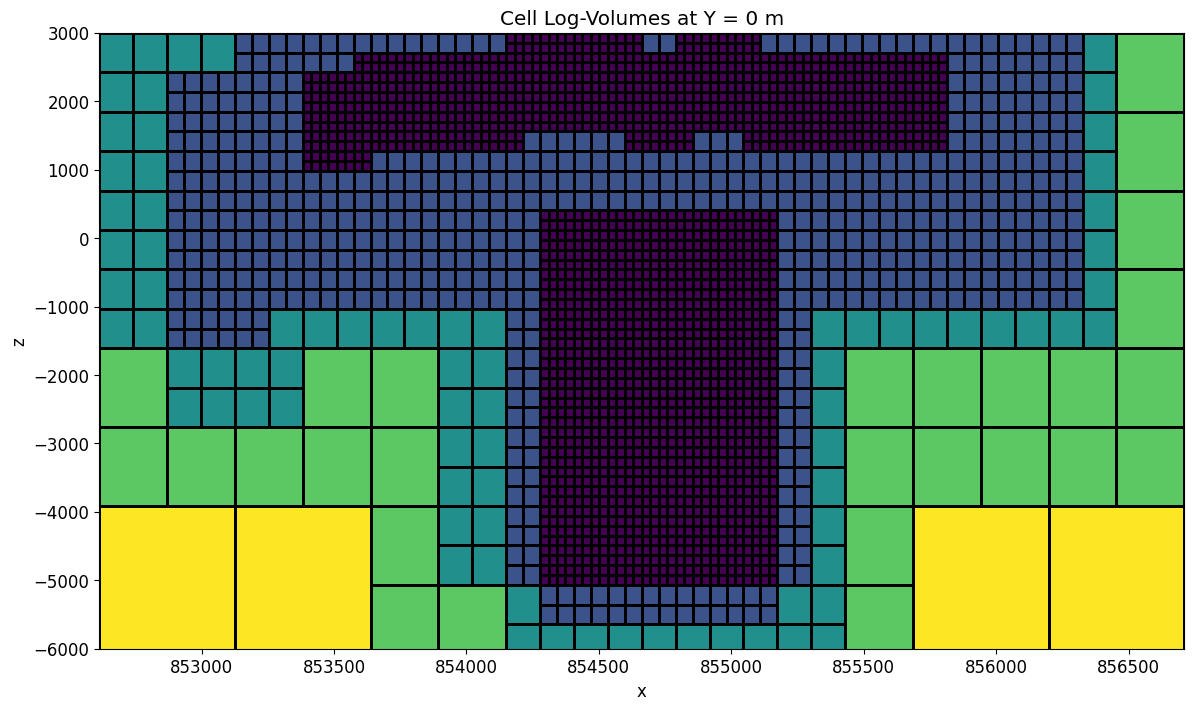

In [38]:
import numpy as np
from discretize import TreeMesh

# Aumenta ligeramente los tamaños de celda mínimos
dx = 32  # incrementado de 32 a 40
dy = 16  # incrementado de 64 a 80
dz = 144  # incrementado de 80 a 100

# Define domain dimensions
x_length = 2954.0
y_length = 1072.0
z_length = 7000.0

# Compute number of base mesh cells required in x, y, and z
nbcx = 2 ** int(np.round(np.log(x_length / dx) / np.log(2.0)))
nbcy = 2 ** int(np.round(np.log(y_length / dy) / np.log(2.0)))
nbcz = 2 ** int(np.round(np.log(z_length / dz) / np.log(2.0)))

# Define the base mesh
hx = [(dx, nbcx)]
hy = [(dy, nbcy)]
hz = [(dz, nbcz)]

# Define starting coordinates
x0 = [852614, 987543, -9000]

# Create mesh
tree_mesh = TreeMesh([hx, hy, hz], x0=x0)

# Shift vertically to top same as maximum topography
tree_mesh.origin += np.r_[0.0, 0.0, xyz_topo[:, -1].max()]

# Refine based on surface topography
tree_mesh.refine_surface(xyz_topo, padding_cells_by_level=[8, 8], finalize=False)

# Refine box based on region of interest
wsb_corner = np.c_[854336., 987813., -5000]
ent_corner = np.c_[855146., 988145., 200]
# Note -1 is a flag for smallest cell size
tree_mesh.refine_box(wsb_corner, ent_corner, levels=[-1], finalize=False)

# Finalize the mesh
tree_mesh.finalize()

# A boolean array specifying which cells lie on the boundary
bInd = tree_mesh.cell_boundary_indices

# Cell volumes
v = tree_mesh.cell_volumes

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)
tree_mesh.plot_slice(
    np.log10(v),
    normal="Y",
    ax=ax,
    ind=int(tree_mesh.h[1].size / 2),
    grid=True)
ax.set_ylim(-6000, 3000)
ax.set_title("Cell Log-Volumes at Y = 0 m")

In [39]:
active_tree_cells = active_from_xyz(tree_mesh, xyz_topo)
n_tree_active = int(active_tree_cells.sum())

In [40]:
tree_model_map = maps.IdentityMap(nP=n_tree_active)

In [41]:
starting_tree_model = 0.5 * np.ones(n_tree_active)
reference_tree_model = np.zeros_like(starting_tree_model)

In [42]:
tree_plotting_map = maps.InjectActiveCells(tree_mesh, active_tree_cells, np.nan)

In [43]:
simulation_irls = gravity.simulation.Simulation3DIntegral(
    survey=survey, 
    mesh=tree_mesh, 
    # rho=None,    
    rhoMap=tree_model_map,
    ind_active=active_tree_cells,
    engine="choclo",
    )

In [44]:
from simpeg import data_misfit

dmis_irls = data_misfit.L2DataMisfit(data=new_data_object, simulation=simulation_irls)


In [45]:
reg_irls = regularization.Sparse(
    tree_mesh,
    active_cells=active_tree_cells,
    alpha_s=dy**-1,
    alpha_x=1,
    alpha_y=1,
    alpha_z=1,
    reference_model=reference_tree_model,
    reference_model_in_smooth=True,
    norms=[2, 2, 2, 2],
)

In [46]:
opt_irls = optimization.ProjectedGNCG(
    maxIter=100, lower=-2.0, upper=2.0, maxIterLS=20, maxIterCG=20, tolCG=1e-2
)

In [47]:
inv_prob_irls = inverse_problem.BaseInvProblem(dmis_irls, reg_irls, opt_irls)

In [48]:
from simpeg import directives

# Options for outputting recovered models and predicted data for each beta.
save_iteration_new = directives.SaveOutputDictEveryIteration()
save_iteration_new.outDict = {}

sensitivity_weights_irls = directives.UpdateSensitivityWeights(every_iteration=True,
                                                               threshold_value=1e-10,
                                                               threshold_method='amplitude',
                                                               normalization_method='maximum')
starting_beta_irls = directives.BetaEstimate_ByEig(beta0_ratio=10)
update_jacobi_irls = directives.UpdatePreconditioner(update_every_iteration=True)

update_irls = directives.Update_IRLS(
    coolingFactor=2.0,
    coolingRate=1,
    chifact_start=2,
    f_min_change=1e-4,
    max_irls_iterations=50,
)

directives_list_irls = [
    update_irls,
    sensitivity_weights_irls,
    starting_beta_irls,
    update_jacobi_irls,
    save_iteration,
]



In [49]:
inv_irls = inversion.BaseInversion(inv_prob_irls, directives_list_irls)
recovered_tree_model = inv_irls.run(starting_tree_model)

c:\Users\gabri\anaconda3\envs\volcan\lib\site-packages\simpeg\directives\directives.py:320: UserWarning: InversionDirective SaveOutputDictEveryIteration has switched to a new inversion.
  d.inversion = i



Running inversion with SimPEG v0.22.1

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.53e+00  1.97e+05  3.15e+06  5.01e+06    7.31e+02      0              
   1  7.63e-01  6.93e+05  5.12e+05  1.08e+06    4.98e+02      0              
   2  3.81e-01  3.16e+05  8.57e+05  6.43e+05    4.67e+02      0              
   3  1.91e-01  1.31e+05  1.19e+06  3.58e+05    4.39e+02      0   Skip BFGS  
   4  9.54e-02  5.41e+04  1.47e+06  1.94e+05    4.13e+02      0   Skip BFGS  
   5  4.77e-02  2.38e+04  1.68e+06  1.04e+05    3.82e+02      0   Skip BFGS  
   6  2.38e-02  1.15e+

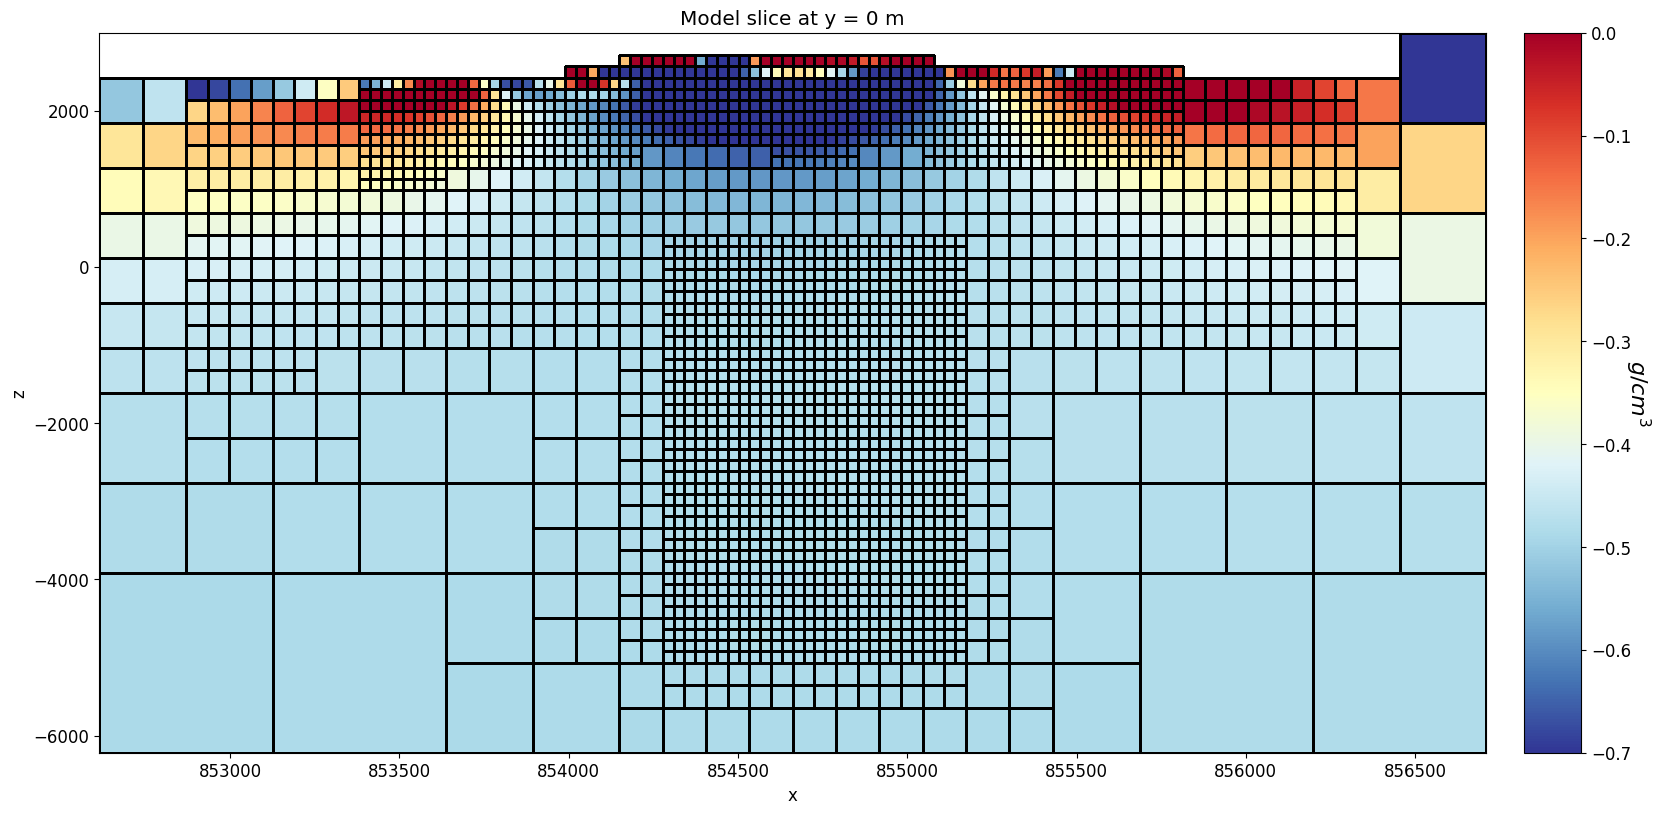

In [50]:
# Plot Recovered Model
fig = plt.figure(figsize=(19, 9))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

# norm = mpl.colors.Normalize(
#     vmin=np.min(recovered_tensor_model), vmax=np.max(recovered_tensor_model)
# )

norm = mpl.colors.Normalize(vmin=-0.7, vmax=0.0)

tree_mesh.plot_slice(
    tree_plotting_map * -recovered_tree_model,
    normal="Y",
    ax=ax1,
    ind=int(tree_mesh.shape_cells[1] / 2),
    grid=True,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)
ax1.set_title("Model slice at y = 0 m")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

plt.show()


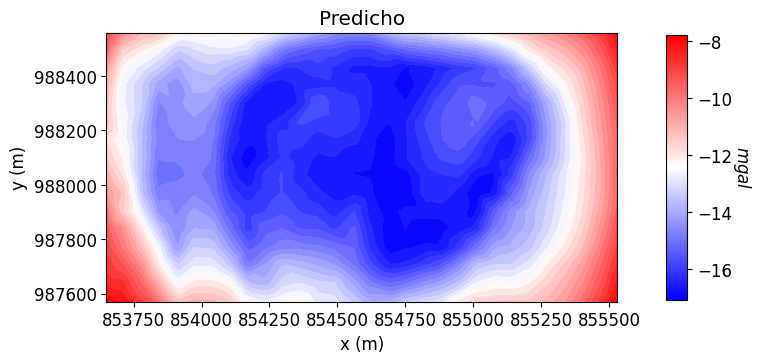

In [51]:
dpred_new = (inv_prob_irls.dpred)

# Plot
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

v_lim = [np.min(dpred_new), np.max(dpred_new), np.min(-dpred_new), np.max(-dpred_new)]

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(
    receiver_list[0].locations,
    dpred_new, 
    ax=ax1,
    ncontour=30,
    clim=(v_lim[0], v_lim[1]),
    contourOpts={"cmap": "bwr"})
ax1.set_title("Predicho")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=v_lim[0], vmax=v_lim[1])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

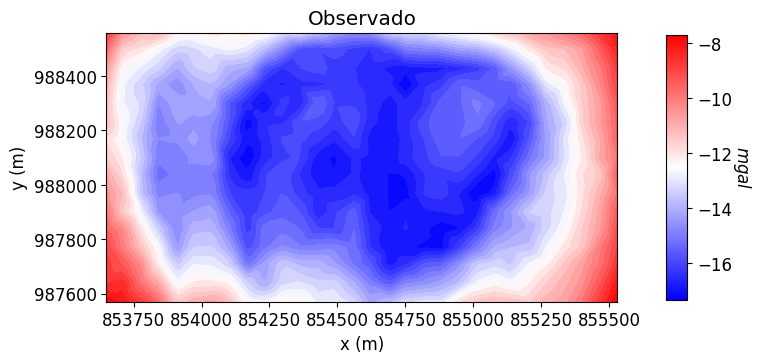

In [52]:
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(receiver_locations, dobs, ax=ax1, ncontour=30, contourOpts={"cmap": "bwr"})
ax1.set_title("Observado")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=-np.max(-dobs), vmax=np.max(dobs))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

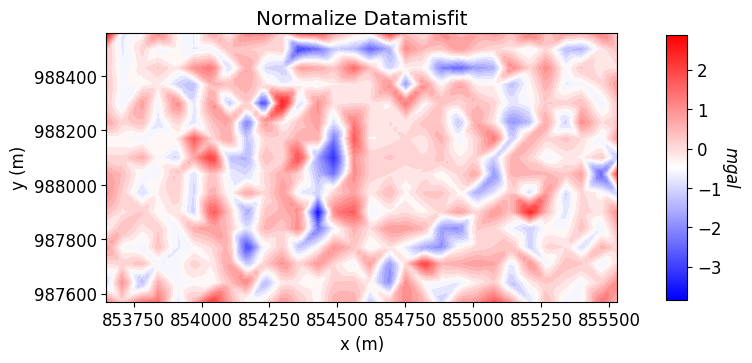

In [53]:
data_misfit_new= (dobs - dpred_new) / new_uncertainties

mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(receiver_locations,
           data_misfit_new,
           ax=ax1,
           ncontour=30,
           contourOpts={"cmap": "bwr"})
ax1.set_title("Normalize Datamisfit")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.9, 0.26, 0.03, 0.53])
norm = mpl.colors.Normalize(vmin=-np.max(-data_misfit_new), vmax=np.max(data_misfit_new))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr,
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

In [54]:
def plot_tikhonov_curve(iteration, scale):
    phi_d = []
    phi_m = []
    beta = []
    iterations = np.arange(len(save_iteration_new.outDict)) + 1
    for kk in iterations:
        phi_d.append(save_iteration_new.outDict[kk]['phi_d'])
        phi_m.append(save_iteration_new.outDict[kk]['phi_m'])
        beta.append(save_iteration_new.outDict[kk]['beta'])
    
    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    
    # Primera gráfica
    axs[0].plot(phi_m, phi_d, 'k.-')
    axs[0].plot(phi_m[iteration-1], phi_d[iteration-1], 'go', ms=10)
    axs[0].set_xlabel("$\phi_m$")
    axs[0].set_ylabel("$\phi_d$")
    axs[0].grid(True)
    
    # Segunda gráfica
    line1 = axs[1].plot(iterations, phi_d, 'k.-', label='$\phi_d$')
    point1 = axs[1].plot(iterations[iteration-1], phi_d[iteration-1], 'go', ms=10)
    
    ax_1 = axs[1].twinx()
    line2 = ax_1.plot(iterations, phi_m, 'r.-', label='$\phi_m$')
    point2 = ax_1.plot(iterations[iteration-1], phi_m[iteration-1], 'go', ms=10)
    
    axs[1].set_ylabel("$\phi_d$")
    ax_1.set_ylabel("$\phi_m$")
    axs[1].set_xlabel("Iterations")
    axs[1].grid(True)
    
    # Añadir leyendas
    lines = line1 + line2
    labels = [line.get_label() for line in lines]
    axs[1].legend(lines, labels, loc='upper left')
    
    axs[0].set_title(
        "$\phi_d$={:.1e}, $\phi_m$={:.1e}, $\\beta$={:.1e}".format(phi_d[iteration-1], phi_m[iteration-1], beta[iteration-1]),
        fontsize = 14
    )
    axs[1].set_title("Target misfit={:.0f}".format(survey.nD/2))
    
    for ii, ax in enumerate(axs):        
        if ii == 0:
            ax.set_xscale(scale)        
        ax.set_yscale(scale)
        xlim = ax.get_xlim()
        ax.hlines(survey.nD/2, xlim[0], xlim[1], linestyle='--', label='$\phi_d^{*}$')
        ax.set_xlim(xlim)
    
    axs[0].legend()
    plt.tight_layout()    

interact(
    plot_tikhonov_curve, 
    iteration=widgets.IntSlider(min=1, max=len(save_iteration_new.outDict), step=1),
    scale=widgets.RadioButtons(options=["linear", "log"])
)

TraitError: setting max < min

In [ ]:
def plot_dobs_vs_dpred(iteration):
    # Predicted data with final recovered model
    dpred_new = save_iteration.outDict[iteration]['dpred']

    # Observed data | Predicted data | Normalized data misfit
    data_array = np.c_[dobs, dpred_new, (dobs - dpred_new) / new_uncertainties]
    vmin, vmax = dobs.min(), dobs.max()
    fig = plt.figure(figsize=(17, 4))
    plot_title = ["Observed", "Predicted", "Normalized Misfit"]
    plot_units = ["nT", "nT", ""]

    ax1 = 3 * [None]
    ax2 = 3 * [None]
    norm = 3 * [None]
    cbar = 3 * [None]
    cplot = 3 * [None]
    v_lim = [(vmin, vmax), (vmin, vmax),(-3,3)]

    for ii in range(0, 3):

        ax1[ii] = fig.add_axes([0.33 * ii + 0.03, 0.11, 0.22, 0.84])
        cplot[ii] = plot2Ddata(
            receiver_list[0].locations,
            data_array[:, ii],
            ax=ax1[ii],
            ncontour=30,
            clim=v_lim[ii],
            contourOpts={"cmap": "Spectral_r"},
        )
        ax1[ii].set_title(plot_title[ii])
        ax1[ii].set_xlabel("x (m)")
        ax1[ii].set_ylabel("y (m)")

        ax2[ii] = fig.add_axes([0.33 * ii + 0.27, 0.11, 0.01, 0.84])
        norm[ii] = mpl.colors.Normalize(vmin=v_lim[ii][0], vmax=v_lim[ii][1])
        cbar[ii] = mpl.colorbar.ColorbarBase(
            ax2[ii], norm=norm[ii], orientation="vertical", cmap=mpl.cm.Spectral_r
        )
        cbar[ii].set_label(plot_units[ii], rotation=270, labelpad=15, size=12)
    for ax in ax1[1:]:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    plt.show()

In [ ]:
interact(plot_dobs_vs_dpred, iteration=widgets.IntSlider(min=1, max=len(save_iteration.outDict), step=1, value=1))

In [ ]:
def plot_recovered_model(iteration, xslice, yslice, zslice, vmax):
    # Recuperar el modelo (asegurándonos de que es el correcto)
    model = save_iteration_new.outDict[iteration]['m']
    
    # Si el modelo tiene más celdas de las que tiene la malla, recortarlo
    if model.size > mesh.nC:
        model = model[:mesh.nC]  # Recortar el modelo a las celdas de la malla

    # Si el modelo tiene menos celdas que la malla, expandirlo (debe alinearse con las celdas activas de la malla)
    if model.size < mesh.nC:
        expanded_model = np.zeros(mesh.nC)  # Crear un modelo vacío para todas las celdas
        expanded_model[:model.size] = model  # Asignar valores a las celdas disponibles
        model = expanded_model  # Usar el modelo expandido

    # Crear la figura para visualizar
    fig = plt.figure(figsize=(10, 10))

    # Graficar usando el modelo ajustado
    mesh.plot_3d_slicer(
        model,  # Usar el modelo ajustado
        clim=(0, vmax),
        xslice=xslice,
        yslice=yslice,
        zslice=zslice,
        fig=fig,
        pcolor_opts={'cmap': 'Spectral_r'}
    )
    sm = plt.cm.ScalarMappable(cmap='Spectral_r', norm=plt.Normalize(vmin=0, vmax=vmax))
    sm._A = []  # Esto es necesario para matplotlib
    cbar = fig.colorbar(sm, ax=fig.axes, orientation='vertical', fraction=0.02, pad=0.1)
    cbar.set_label('Density (g/cm³)', rotation=270, labelpad=20)

        # Configurar el título
    plt.suptitle(f'Recovered Model - Iteration {iteration}', fontsize=16)
    plt.show()
    

# Configurar widgets interactivos
interact(
    plot_recovered_model, 
    iteration=widgets.IntSlider(min=1, max=len(save_iteration_new.outDict), value=0),
    xslice=widgets.FloatText(value=854500, step=200),
    yslice=widgets.FloatText(value=988000, step=200), 
    zslice=widgets.FloatText(value=2000, step=200),
    vmax=widgets.FloatText(value=0.7)
)


In [ ]:
def plot_3d_with_pyvista(model, notebook=True, threshold=-0.0):
    pv.set_plot_theme("document")
    
    # Verificar y ajustar el tamaño del modelo
    if isinstance(model, np.ndarray):
        # Si el modelo es un array de NumPy, asegurarse de que tenga el tamaño correcto
        if model.size > mesh.nC:
            # Si el modelo es más grande, truncarlo
            model = model[:mesh.nC]
        elif model.size < mesh.nC:
            # Si el modelo es más pequeño, expandirlo con ceros
            expanded_model = np.zeros(mesh.nC)
            expanded_model[:model.size] = model
            model = expanded_model
    
    # Convertir la malla a un dataset de PyVista
    dataset = mesh.to_vtk({'Densidad': model})
    
    # Crear la escena de renderizado
    p = pv.Plotter(notebook=notebook)
    p.hide_axes()  # Ocultar los ejes para una visualización más limpia
    
    # Filtrar por un umbral
    threshed = dataset.threshold(threshold, invert=True)
    
    # Calcular los límites de los colores con base en los valores del modelo
    clim = [model.min(), model.max()]
    
    # Definir argumentos de la barra de colores
    scalar_bar_args = {
        'title': 'mGal',  # Título de la barra de colores
        'vertical': False
    }
    
    # Agregar los datos volumétricos a la escena
    dparams = dict(
        show_edges=False,
        cmap="Spectral",
        clim=clim,
        scalar_bar_args=scalar_bar_args,  # Argumentos de la barra de colores
    )
    p.add_mesh(threshed, **dparams)
    
    # Ajustar la escala y la posición de la cámara
    p.set_scale(1, 1, 0.1)
    
    # Mostrar la escena
    p.show(window_size=[1024, 768])

# Llamar a la función con el modelo expandido
plot_3d_with_pyvista(recovered_tree_model, notebook=False, threshold=-0.5)